##### Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# **Lucent Feature Identification Basics**

While we provide the framework for the objective of a neural network, we do not understand the internal algorithms, circuits, neurons, features, etc. that a neural network relies upon to complete our given objective. Mechanistic Interpretability attempts to answer the question of what is going on within neural networks.

This notebook combines the lucent notebooks for the **diversity objective**, **activation grid**, and **feature inversions** into one example that can begin to create a picture of the internal functions of a neural network based on the features upon which the network fires.

## Install, Import, Load Model

In [ ]:
!pip install --quiet git+https://github.com/greentfrapp/lucent.git

# load example image into colab /content/.. files
!wget https://github.com/jillian-haffner/ai_feature_interpretation/blob/main/dogandcat_adjusted.png?raw=true -O /content/dogandcat.png

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.4/899.4 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.6/234.6 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.5 MB/s eta 0:00:00
--2024-11-08 00:08:15--  https://github.com/jillian-haffner/ai_feature_interpretation/blob/main/dogandcat_adjusted.png?raw=true
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/jillian-haffner/ai_feature_interpretation/raw/refs/heads/main/dogandcat_adjusted.png [following]
--2024-11-08 00:08:15--  https://github.com/jillian-haffner/ai_feature_interpretation/raw/refs/heads/main/dogandcat_adjusted.png
Reusing existing connection to github.com:443.

In [ ]:
from PIL import Image
from itertools import product
import sys
import numpy as np
import scipy.ndimage as nd
import torch
import torchvision

from google.colab import files

from lucent.optvis import render, param, transform, objectives
from lucent.modelzoo import *
from lucent.misc.io import show
from lucent.misc.channel_reducer import ChannelReducer

import matplotlib.pylab as plt
import matplotlib.image as mpimg

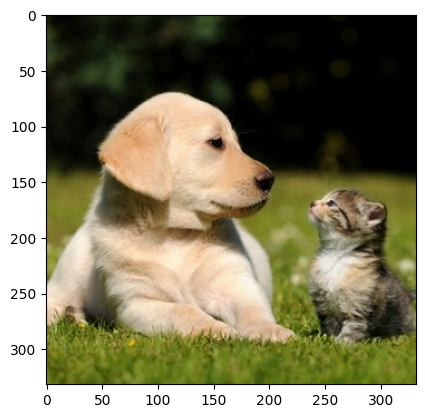

In [ ]:
def print_pic(img_obj):
  fig, axs = plt.subplots(1, 1)
  axs.imshow(img_obj)
  plt.show()

print_pic(mpimg.imread('/content/dogandcat.png'))

In [ ]:
# set which model to use in the example
model_type = 'inceptionv1' #@param ['inceptionv1', 'resnet50']
steps = 1024 # @param {"type":"integer"}
  # use 1024 steps for inception and 512 steps for resnet

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# load in image for the example
dogcat_img = np.array(Image.open("dogandcat.png"), np.float32)
dogcat_img = dogcat_img[:, :, :3]   # drop transparency layer of image

In [ ]:
# set which layers to view for model type
if model_type == 'inceptionv1':
  model = inceptionv1(pretrained=True)
  _ = model.to(device).eval()
  layers = ['mixed4a','mixed4b',
            # 'mixed4e', 'mixed5a', 'mixed5b'
            ]
if model_type == 'resnet50':
  model = resnet50(pretrained=True)
  _ = model.to(device).eval()
  layers = ['layer2', 'layer3', 'layer4',
            # 'avgpool'
            ]

Downloading: "https://github.com/ProGamerGov/pytorch-old-tensorflow-models/raw/master/inception5h.pth" to /root/.cache/torch/hub/checkpoints/inception5h.pth
100%|██████████| 27.0M/27.0M [00:00<00:00, 163MB/s] 


In [ ]:
# import PIL
# from PIL import Image

# convert Pytorch tensor to numpy array
def tensor_to_nparray(tensor):
  image = tensor.cpu().detach().numpy()
  image = np.transpose(image, [2, 1, 0])
  # Check if the image is single channel and convert to 3-channel
  if len(image.shape) == 4 and image.shape[3] == 1:  # Single channel image
     image = np.repeat(image, 3, axis=3)
  return image


# save numpy array as image file accessible in Colab notebooks
def export_custom(image, image_name=None):
  image_name = image_name or "img.jpg"
  if len(image.shape) == 4 and image.shape[3] == 1:  # Single channel image
      image = np.repeat(image, 3, axis=3)
  assert len(image.shape) in [
      3,
      4,
  ], "Image should have 3 or 4 dimensions, invalid image shape {}".format(image.shape)
  # Change dtype for PIL.Image
  image = (image * 255).astype(np.uint8)
  if len(image.shape) == 4:
      image = np.concatenate(image, axis=1)
  Image.fromarray(image).save(image_name)


#
def append_to_pos(array, filename, image, layer, p):
  array[p][1].append(grid_image(filename, layer, image))
  return array

In [ ]:
import warnings
from tqdm import tqdm
from PIL import Image

# render_vis from lucent.optvis.render with some tweaks for this example
def render_vis_custom(
    model,
    objective_f,
    param_f=None,
    optimizer=None,
    transforms=None,
    thresholds=(512,),
    verbose=False,
    preprocess=True,
    progress=True,
    show_image=True,
    save_image=False,
    image_name=None,
    show_inline=False,
    fixed_image_size=None,
    hook_bool=True
):
    if param_f is None:
        param_f = lambda: param.image(128, device=next(model.parameters()).device)
    # param_f is a function that should return two things
    # params - parameters to update, which we pass to the optimizer
    # image_f - a function that returns an image as a tensor
    params, image_f = param_f()

    if optimizer is None:
        optimizer = lambda params: torch.optim.Adam(params, lr=5e-2)
    optimizer = optimizer(params)

    if transforms is None:
        transforms = transform.standard_transforms
    transforms = transforms.copy()

    if preprocess:
        if model._get_name() == "InceptionV1":
            # Original Tensorflow InceptionV1 takes input range [-117, 138]
            transforms.append(transform.preprocess_inceptionv1())
        else:
            transforms.append(transform.normalize())

    # Upsample images smaller than 224
    image_shape = image_f().shape
    if fixed_image_size is not None:
        new_size = fixed_image_size
    elif image_shape[2] < 224 or image_shape[3] < 224:
        new_size = 224
    else:
        new_size = None
    if new_size:
        transforms.append(
            torch.nn.Upsample(size=new_size, mode="bilinear", align_corners=True)
        )

    transform_f = transform.compose(transforms)

    hook, features = render.hook_model(model, image_f, return_hooks=True)
    objective_f = objectives.as_objective(objective_f)

    if verbose:
        model(transform_f(image_f()))
        print("Initial loss: {:.3f}".format(objective_f(hook)))

    images = []
    try:
        for i in tqdm(range(1, max(thresholds) + 1), disable=(not progress)):
            def closure():
                optimizer.zero_grad()
                try:
                    model(transform_f(image_f()))
                except RuntimeError as ex:
                    if i == 1:
                        # warning not needed on other iterations
                        warnings.warn(
                            "Some layers could not be computed because the size of the "
                            "image is not big enough. It is fine, as long as the non"
                            "computed layers are not used in the objective function"
                            f"(exception details: '{ex}')"
                        )
                loss = objective_f(hook)
                loss.backward()
                return loss

            optimizer.step(closure)
            if i in thresholds:
                image = render.tensor_to_img_array(image_f())
                if verbose:
                    print("Loss at step {}: {:.3f}".format(i, objective_f(hook)))
                    if show_inline:
                        show(image)
                images.append(image)
    except KeyboardInterrupt:
        print("Interrupted optimization at step {:d}.".format(i))
        if verbose:
            print("Loss at step {}: {:.3f}".format(i, objective_f(hook)))
        images.append(render.tensor_to_img_array(image_f()))

    if hook_bool:
      # Clear hooks
      for module_hook in features.values():
          del module_hook.module._forward_hooks[module_hook.hook.id]

    if save_image:
        render.export(image_f(), image_name)
    if show_inline:
        show(render.tensor_to_img_array(image_f()))
    elif show_image:
        render.view(image_f())
    return images

## Diversity Objective (Optional)


With the diversity objective, we have to submit a batch of images for optimization. The diversity objective then tries to maximize the difference in feature representations between the images in the batch.

Specifically, the objective penalizes cosine similarity between the feature representations.

mixed4a @ 63


100%|██████████| 512/512 [00:34<00:00, 14.81it/s]



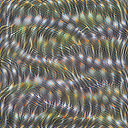
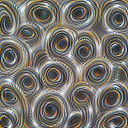
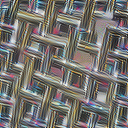
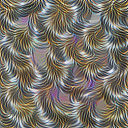

mixed4b @ 63


100%|██████████| 512/512 [00:25<00:00, 20.17it/s]



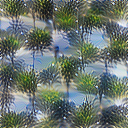
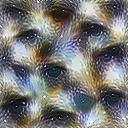
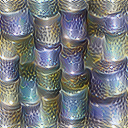
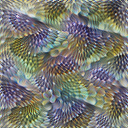

In [ ]:
batch_param_f = lambda: param.image(128, batch=4) #, decorrelate=False) # disable channel decorrelation for less interpretable images


for layer in layers:
  print(layer + ' @ 63')
  obj = objectives.channel(layer, 63) - 1e3 * objectives.diversity(layer)
  current = render_vis_custom(model, obj, batch_param_f, save_image=False, image_name='divobj_{}.jpg'.format(layer), show_inline=True)

## Activation Grid



In [ ]:
@torch.no_grad()
def get_layer(model, layer, X):
    hook = render.ModuleHook(getattr(model, layer))
    model(X)
    hook.close()
    return hook.features


@objectives.wrap_objective()
def dot_compare(layer, acts, batch=1):
    def inner(T):
        pred = T(layer)[batch]
        return -(pred * acts).sum(dim=0, keepdims=True).mean()

    return inner

In [ ]:
# render_activation_grid_less_naive from lucent activation_grids.ipynb
# with some tweaks for this example
def render_activation_grid_less_naive_custom(
    img,
    model,
    layer="mixed4d",
    cell_image_size=60,
    n_groups=6,
    n_steps=1024,
    batch_size=64
):
    # normalize and resize the image
    img = torch.tensor(np.transpose(img, [2, 0, 1])).to(device)
    normalize = (
        transform.preprocess_inceptionv1()
        if model._get_name() == "InceptionV1"
        else transform.normalize()
    )
    transforms = transform.standard_transforms.copy() + [
        normalize,
        torch.nn.Upsample(size=224, mode="bilinear", align_corners=True),
    ]
    transforms_f = transform.compose(transforms)
    # shape: (1, 3, original height of img, original width of img)
    img = img.unsqueeze(0)
    # shape: (1, 3, 224, 224)
    img = transforms_f(img)

    # compute the activations of the layer `layer` using `img` as input
    # shape: (layer_channels, layer_height, layer_width)
    acts = get_layer(model, layer, img)[0]
    # shape: (layer_height, layer_width, layer_channels)
    acts = acts.permute(1, 2, 0)
    # shape: (layer_height*layer_width, layer_channels)
    acts = acts.view(-1, acts.shape[-1])
    acts_np = acts.cpu().numpy()
    nb_cells = acts.shape[0]

    # NEGATIVE MATRIX FACTORIZATION:
    # `NMF` is used to reduce the number of channels to n_groups...
    # Each cell image is decomposed into a sum of (n_groups+1) images parametrized
    # by 'cells_params'. There is also a group of images of size 'n_groups' that
    # has its own images parametrized by `groups_params`. The resulting image for
    # a given cell in the grid is the sum of its own image plus a weighted sum of
    # the images of the group. Each each image from the group is weighted by
    # `groups[cell_index, group_idx]`. This makes cells with similar activations
    # have a similar image.
    if n_groups > 0:
        reducer = ChannelReducer(n_groups, "NMF")
        groups = reducer.fit_transform(acts_np)
        groups /= groups.max(0)
    else:
        groups = np.zeros([])
    # shape: (layer_height*layer_width, n_groups)
    groups = torch.from_numpy(groups)

    # Parametrization of the images of the groups
    groups_params, groups_image_f = param.fft_image(
        [n_groups, 3, cell_image_size, cell_image_size]
    )
    # Parametrization of the images of each cell in the grid
    cells_params, cells_image_f = param.fft_image(
        [nb_cells, 3, cell_image_size, cell_image_size]
    )

    # construct images
    def image_f():
        groups_images = groups_image_f()
        cells_images = cells_image_f()
        X = []
        for i in range(nb_cells):
            x = 0.7 * cells_images[i] + 0.5 * sum(
                groups[i, j] * groups_images[j] for j in range(n_groups)
            )
            X.append(x)
        X = torch.stack(X)
        return X

    # make sure the images are between 0 and 1
    image_f = param.to_valid_rgb(image_f, decorrelate=True)

    # randomly sample mini-batch of cells from grid to prevent memory overflow
    def sample(image_f, batch_size):
        def f():
            X = image_f()
            inds = torch.randint(0, len(X), size=(batch_size,))
            inputs = X[inds]
            sample.inds = inds
            return inputs

        return f

    image_f_sampled = sample(image_f, batch_size=batch_size)

    def objective_func(model):
        # shape: (batch_size, layer_channels, cell_layer_height, cell_layer_width)
        pred = model(layer)
        # use the sampled indices from `sample` to get the corresponding targets
        target = acts[sample.inds].to(pred.device)
        # shape: (batch_size, layer_channels, 1, 1)
        target = target.view(target.shape[0], target.shape[1], 1, 1)
        dot = (pred * target).sum(dim=1).mean()
        return -dot

    obj = objectives.Objective(objective_func)

    def param_f():
        # optimize the parametrizations of both the groups and the cells
        params = list(groups_params) + list(cells_params)
        return params, image_f_sampled


    _ = render_vis_custom(
        model,
        obj,
        param_f,
        thresholds=(n_steps,),
        show_image=False,
        progress=True,
        fixed_image_size=cell_image_size,
        hook_bool=False
    )

    # shape: (layer_height*layer_width, 3, grid_image_size, grid_image_size)
    imgs = image_f()
    imgs = imgs.cpu().data
    imgs = imgs[:, :, 2:-2, 2:-2]
    # turn imgs into a a grid
    grid = torchvision.utils.make_grid(imgs, nrow=int(np.sqrt(nb_cells)), padding=0)
    grid = grid.permute(1, 2, 0)
    grid = grid.numpy()
    show(grid)
    return imgs, image_f()

In [ ]:
act_grid_img = dogcat_img

# create array to hold images in each layer's activation grid
grid_images = [[]] * (len(layers))


# create activation grid for each chosen layer
for i in range(len(layers)):
  # grid_images[i][0] = layers[i]

  _, current_grid_img = render_activation_grid_less_naive_custom(act_grid_img,
                          model, layers[i], cell_image_size=60, n_steps=steps,
                          batch_size=64
                          )
  render.export(current_grid_img, '{}_grid.jpg'.format(layers[i]))

  # save individaul grid images and add to grid_images array
  for j in range(len(current_grid_img)):
    current_tensor = tensor_to_nparray(current_grid_img[j])
    image_name = '{}_{}_{}.jpg'.format(model_type, layers[i], j)

    export_custom(current_tensor, image_name)
    current_image = Image.open(image_name)
    grid_images[i].append(current_image)

## Zero-Shot Classification of Features

In [ ]:
!pip install --quiet torch transformers datasets

from transformers import pipeline
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
from transformers.models.clip.processing_clip import CLIPProcessor
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
checkpoint = "openai/clip-vit-large-patch14"
classifier = pipeline(model=checkpoint, task="zero-shot-image-classification")

# add to these for more classification options
candidate_labels = ['snout', 'ears', 'eyes', 'wings', 'beak',
                    'wheels', 'windows', 'doors',
                    'fur', 'stripes', 'hair', 'fluff', 'skin', 'clothing',
                    'grass', 'trees', 'bushes', 'clouds', 'water', 'sky'
                    ]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
import random

random_nums = random.sample(range(1, 196), 7)

mixed4a, image 2


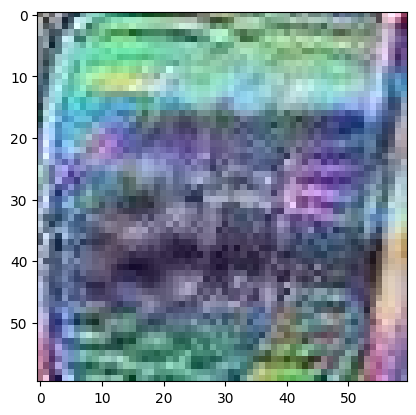

[{'score': 0.3039035201072693, 'label': 'skin'}, {'score': 0.09961377084255219, 'label': 'stripes'}, {'score': 0.09422450512647629, 'label': 'grass'}, {'score': 0.06324075907468796, 'label': 'windows'}, {'score': 0.05778149142861366, 'label': 'eyes'}, {'score': 0.055228523910045624, 'label': 'clothing'}, {'score': 0.046021491289138794, 'label': 'snout'}, {'score': 0.045149948447942734, 'label': 'hair'}, {'score': 0.04136267676949501, 'label': 'wheels'}, {'score': 0.030835842713713646, 'label': 'sky'}, {'score': 0.028316697105765343, 'label': 'water'}, {'score': 0.026692206040024757, 'label': 'beak'}, {'score': 0.020064499229192734, 'label': 'clouds'}, {'score': 0.019992414861917496, 'label': 'fur'}, {'score': 0.01743270456790924, 'label': 'bushes'}, {'score': 0.01527230441570282, 'label': 'fluff'}, {'score': 0.012768254615366459, 'label': 'wings'}, {'score': 0.012455386109650135, 'label': 'ears'}, {'score': 0.006244377698749304, 'label': 'doors'}, {'score': 0.003398657077923417, 'label

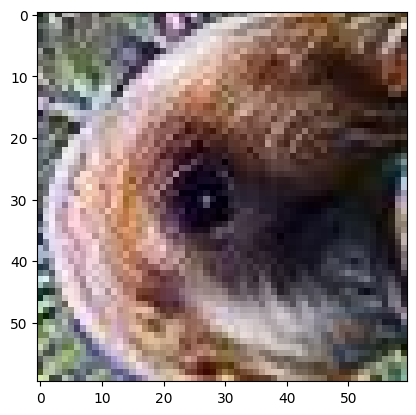

[{'score': 0.7239128351211548, 'label': 'snout'}, {'score': 0.054405417293310165, 'label': 'eyes'}, {'score': 0.03576606884598732, 'label': 'ears'}, {'score': 0.03228182718157768, 'label': 'beak'}, {'score': 0.03161013498902321, 'label': 'sky'}, {'score': 0.029985299333930016, 'label': 'fluff'}, {'score': 0.02490951679646969, 'label': 'stripes'}, {'score': 0.018548857420682907, 'label': 'wings'}, {'score': 0.018256792798638344, 'label': 'wheels'}, {'score': 0.00897356029599905, 'label': 'grass'}, {'score': 0.005808382295072079, 'label': 'fur'}, {'score': 0.004033675882965326, 'label': 'skin'}, {'score': 0.002662509214133024, 'label': 'clouds'}, {'score': 0.0022234220523387194, 'label': 'windows'}, {'score': 0.0018568423110991716, 'label': 'bushes'}, {'score': 0.001637912355363369, 'label': 'hair'}, {'score': 0.0012113982811570168, 'label': 'clothing'}, {'score': 0.0008449385059066117, 'label': 'water'}, {'score': 0.0006180977215990424, 'label': 'trees'}, {'score': 0.0004524554242379963

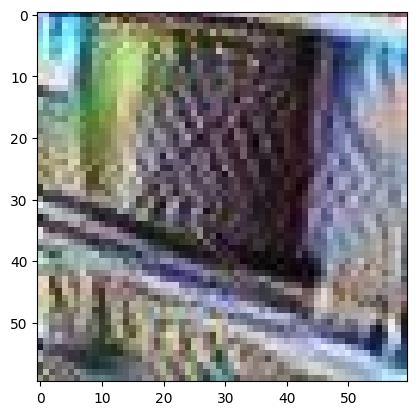

[{'score': 0.34198686480522156, 'label': 'stripes'}, {'score': 0.13134317100048065, 'label': 'beak'}, {'score': 0.10181231051683426, 'label': 'skin'}, {'score': 0.07828720659017563, 'label': 'snout'}, {'score': 0.06063278391957283, 'label': 'grass'}, {'score': 0.046897370368242264, 'label': 'clothing'}, {'score': 0.03387795388698578, 'label': 'windows'}, {'score': 0.033672064542770386, 'label': 'water'}, {'score': 0.028006048873066902, 'label': 'eyes'}, {'score': 0.02139824442565441, 'label': 'wheels'}, {'score': 0.021014967933297157, 'label': 'sky'}, {'score': 0.02062407322227955, 'label': 'doors'}, {'score': 0.019075604155659676, 'label': 'ears'}, {'score': 0.01722315140068531, 'label': 'hair'}, {'score': 0.011561864987015724, 'label': 'bushes'}, {'score': 0.011055642738938332, 'label': 'fluff'}, {'score': 0.00653454102575779, 'label': 'wings'}, {'score': 0.006510518025606871, 'label': 'clouds'}, {'score': 0.0044775973074138165, 'label': 'trees'}, {'score': 0.004008069634437561, 'lab

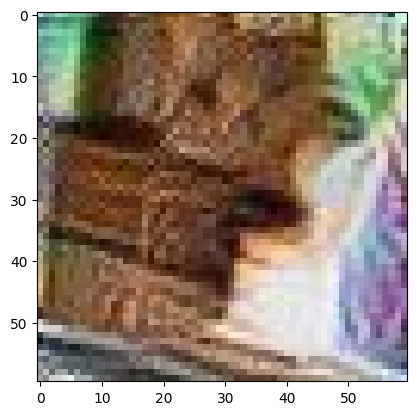

[{'score': 0.30531710386276245, 'label': 'snout'}, {'score': 0.21996073424816132, 'label': 'beak'}, {'score': 0.06728876382112503, 'label': 'skin'}, {'score': 0.049625083804130554, 'label': 'stripes'}, {'score': 0.04711250215768814, 'label': 'clothing'}, {'score': 0.04532303288578987, 'label': 'grass'}, {'score': 0.04211666062474251, 'label': 'windows'}, {'score': 0.03460321202874184, 'label': 'ears'}, {'score': 0.03155457600951195, 'label': 'eyes'}, {'score': 0.023100972175598145, 'label': 'sky'}, {'score': 0.021748758852481842, 'label': 'doors'}, {'score': 0.021081632003188133, 'label': 'bushes'}, {'score': 0.017629822716116905, 'label': 'clouds'}, {'score': 0.017306450754404068, 'label': 'hair'}, {'score': 0.016219235956668854, 'label': 'fluff'}, {'score': 0.011061728931963444, 'label': 'wheels'}, {'score': 0.010006999596953392, 'label': 'trees'}, {'score': 0.0065904418006539345, 'label': 'water'}, {'score': 0.006204807199537754, 'label': 'fur'}, {'score': 0.006147556006908417, 'lab

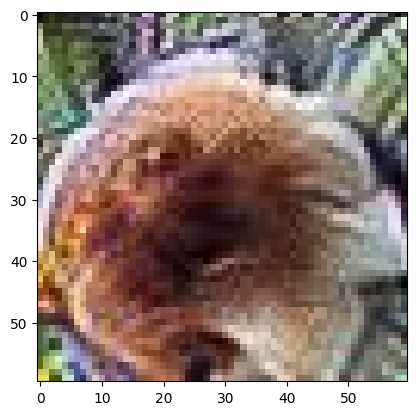

[{'score': 0.47838133573532104, 'label': 'snout'}, {'score': 0.13650572299957275, 'label': 'hair'}, {'score': 0.12315339595079422, 'label': 'ears'}, {'score': 0.07926729321479797, 'label': 'fluff'}, {'score': 0.036244168877601624, 'label': 'grass'}, {'score': 0.024873150512576103, 'label': 'beak'}, {'score': 0.020964397117495537, 'label': 'stripes'}, {'score': 0.017714032903313637, 'label': 'sky'}, {'score': 0.017359256744384766, 'label': 'clouds'}, {'score': 0.01662474125623703, 'label': 'fur'}, {'score': 0.012809292413294315, 'label': 'bushes'}, {'score': 0.008879457600414753, 'label': 'eyes'}, {'score': 0.0071055651642382145, 'label': 'wings'}, {'score': 0.006740527227520943, 'label': 'wheels'}, {'score': 0.005443029571324587, 'label': 'skin'}, {'score': 0.0027553015388548374, 'label': 'windows'}, {'score': 0.002587161958217621, 'label': 'clothing'}, {'score': 0.0010740103898569942, 'label': 'trees'}, {'score': 0.0010547307319939137, 'label': 'water'}, {'score': 0.000463369302451610

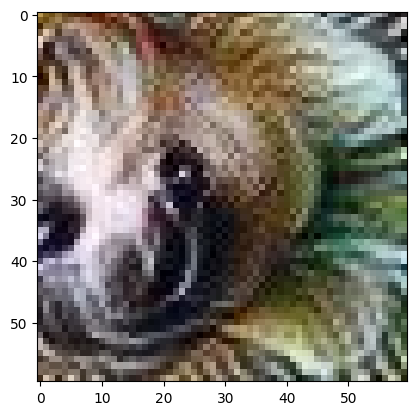

[{'score': 0.2734731137752533, 'label': 'stripes'}, {'score': 0.2641175389289856, 'label': 'snout'}, {'score': 0.10528557002544403, 'label': 'fluff'}, {'score': 0.059193264693021774, 'label': 'beak'}, {'score': 0.04036129638552666, 'label': 'fur'}, {'score': 0.03821279853582382, 'label': 'eyes'}, {'score': 0.036631882190704346, 'label': 'grass'}, {'score': 0.027014054358005524, 'label': 'skin'}, {'score': 0.025271572172641754, 'label': 'hair'}, {'score': 0.023694893345236778, 'label': 'wings'}, {'score': 0.023467307910323143, 'label': 'sky'}, {'score': 0.018087152391672134, 'label': 'wheels'}, {'score': 0.016681840643286705, 'label': 'ears'}, {'score': 0.014122416265308857, 'label': 'windows'}, {'score': 0.01128965150564909, 'label': 'bushes'}, {'score': 0.006737726740539074, 'label': 'clouds'}, {'score': 0.006104562431573868, 'label': 'clothing'}, {'score': 0.004541052971035242, 'label': 'trees'}, {'score': 0.0035037670750170946, 'label': 'doors'}, {'score': 0.0022085383534431458, 'la

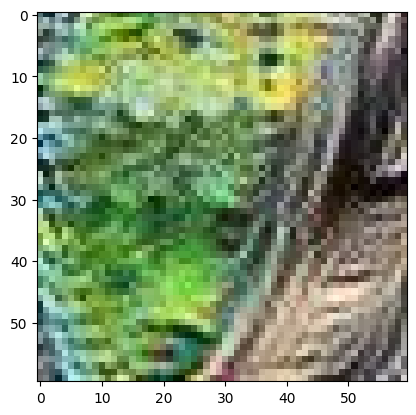

[{'score': 0.22845467925071716, 'label': 'grass'}, {'score': 0.1807645857334137, 'label': 'beak'}, {'score': 0.11228232085704803, 'label': 'bushes'}, {'score': 0.09025907516479492, 'label': 'skin'}, {'score': 0.07226519286632538, 'label': 'snout'}, {'score': 0.06793505698442459, 'label': 'eyes'}, {'score': 0.04045607149600983, 'label': 'stripes'}, {'score': 0.036640800535678864, 'label': 'trees'}, {'score': 0.031134866178035736, 'label': 'windows'}, {'score': 0.025183742865920067, 'label': 'ears'}, {'score': 0.02373816817998886, 'label': 'hair'}, {'score': 0.020760396495461464, 'label': 'clothing'}, {'score': 0.013701098039746284, 'label': 'sky'}, {'score': 0.012202732264995575, 'label': 'clouds'}, {'score': 0.010869576595723629, 'label': 'fur'}, {'score': 0.010704835876822472, 'label': 'wings'}, {'score': 0.008592919446527958, 'label': 'water'}, {'score': 0.006415393203496933, 'label': 'fluff'}, {'score': 0.0038716255221515894, 'label': 'doors'}, {'score': 0.003766885958611965, 'label

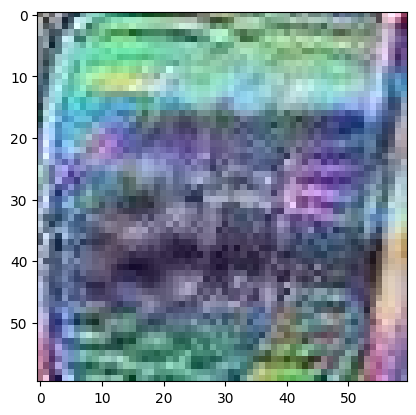

[{'score': 0.3039035201072693, 'label': 'skin'}, {'score': 0.09961377084255219, 'label': 'stripes'}, {'score': 0.09422450512647629, 'label': 'grass'}, {'score': 0.06324075907468796, 'label': 'windows'}, {'score': 0.05778149142861366, 'label': 'eyes'}, {'score': 0.055228523910045624, 'label': 'clothing'}, {'score': 0.046021491289138794, 'label': 'snout'}, {'score': 0.045149948447942734, 'label': 'hair'}, {'score': 0.04136267676949501, 'label': 'wheels'}, {'score': 0.030835842713713646, 'label': 'sky'}, {'score': 0.028316697105765343, 'label': 'water'}, {'score': 0.026692206040024757, 'label': 'beak'}, {'score': 0.020064499229192734, 'label': 'clouds'}, {'score': 0.019992414861917496, 'label': 'fur'}, {'score': 0.01743270456790924, 'label': 'bushes'}, {'score': 0.01527230441570282, 'label': 'fluff'}, {'score': 0.012768254615366459, 'label': 'wings'}, {'score': 0.012455386109650135, 'label': 'ears'}, {'score': 0.006244377698749304, 'label': 'doors'}, {'score': 0.003398657077923417, 'label

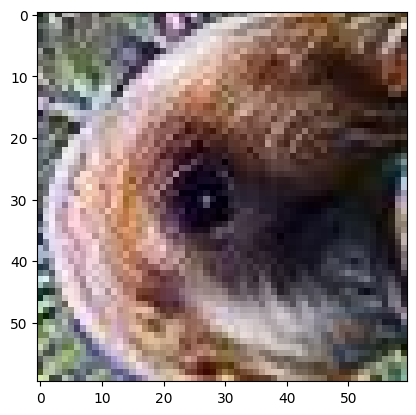

[{'score': 0.7239128351211548, 'label': 'snout'}, {'score': 0.054405417293310165, 'label': 'eyes'}, {'score': 0.03576606884598732, 'label': 'ears'}, {'score': 0.03228182718157768, 'label': 'beak'}, {'score': 0.03161013498902321, 'label': 'sky'}, {'score': 0.029985299333930016, 'label': 'fluff'}, {'score': 0.02490951679646969, 'label': 'stripes'}, {'score': 0.018548857420682907, 'label': 'wings'}, {'score': 0.018256792798638344, 'label': 'wheels'}, {'score': 0.00897356029599905, 'label': 'grass'}, {'score': 0.005808382295072079, 'label': 'fur'}, {'score': 0.004033675882965326, 'label': 'skin'}, {'score': 0.002662509214133024, 'label': 'clouds'}, {'score': 0.0022234220523387194, 'label': 'windows'}, {'score': 0.0018568423110991716, 'label': 'bushes'}, {'score': 0.001637912355363369, 'label': 'hair'}, {'score': 0.0012113982811570168, 'label': 'clothing'}, {'score': 0.0008449385059066117, 'label': 'water'}, {'score': 0.0006180977215990424, 'label': 'trees'}, {'score': 0.0004524554242379963

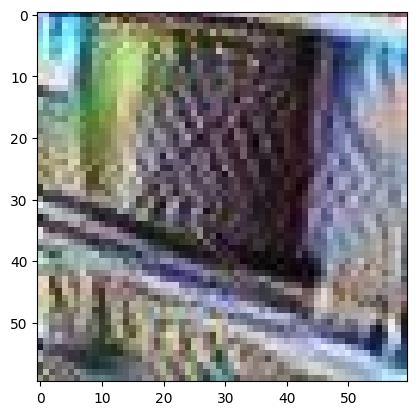

[{'score': 0.34198686480522156, 'label': 'stripes'}, {'score': 0.13134317100048065, 'label': 'beak'}, {'score': 0.10181231051683426, 'label': 'skin'}, {'score': 0.07828720659017563, 'label': 'snout'}, {'score': 0.06063278391957283, 'label': 'grass'}, {'score': 0.046897370368242264, 'label': 'clothing'}, {'score': 0.03387795388698578, 'label': 'windows'}, {'score': 0.033672064542770386, 'label': 'water'}, {'score': 0.028006048873066902, 'label': 'eyes'}, {'score': 0.02139824442565441, 'label': 'wheels'}, {'score': 0.021014967933297157, 'label': 'sky'}, {'score': 0.02062407322227955, 'label': 'doors'}, {'score': 0.019075604155659676, 'label': 'ears'}, {'score': 0.01722315140068531, 'label': 'hair'}, {'score': 0.011561864987015724, 'label': 'bushes'}, {'score': 0.011055642738938332, 'label': 'fluff'}, {'score': 0.00653454102575779, 'label': 'wings'}, {'score': 0.006510518025606871, 'label': 'clouds'}, {'score': 0.0044775973074138165, 'label': 'trees'}, {'score': 0.004008069634437561, 'lab

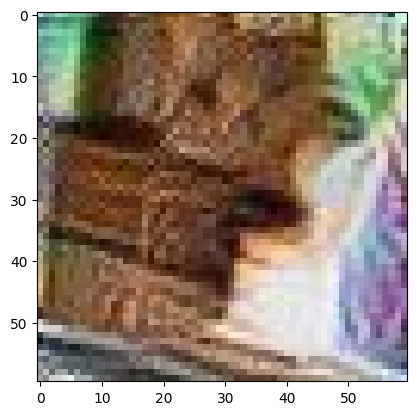

[{'score': 0.30531710386276245, 'label': 'snout'}, {'score': 0.21996073424816132, 'label': 'beak'}, {'score': 0.06728876382112503, 'label': 'skin'}, {'score': 0.049625083804130554, 'label': 'stripes'}, {'score': 0.04711250215768814, 'label': 'clothing'}, {'score': 0.04532303288578987, 'label': 'grass'}, {'score': 0.04211666062474251, 'label': 'windows'}, {'score': 0.03460321202874184, 'label': 'ears'}, {'score': 0.03155457600951195, 'label': 'eyes'}, {'score': 0.023100972175598145, 'label': 'sky'}, {'score': 0.021748758852481842, 'label': 'doors'}, {'score': 0.021081632003188133, 'label': 'bushes'}, {'score': 0.017629822716116905, 'label': 'clouds'}, {'score': 0.017306450754404068, 'label': 'hair'}, {'score': 0.016219235956668854, 'label': 'fluff'}, {'score': 0.011061728931963444, 'label': 'wheels'}, {'score': 0.010006999596953392, 'label': 'trees'}, {'score': 0.0065904418006539345, 'label': 'water'}, {'score': 0.006204807199537754, 'label': 'fur'}, {'score': 0.006147556006908417, 'lab

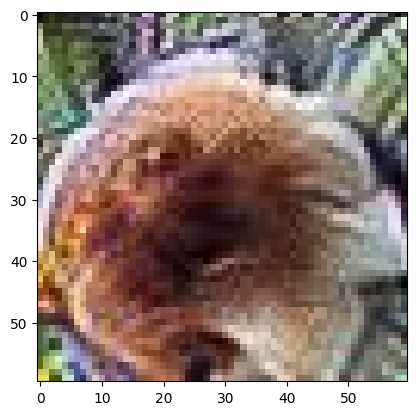

[{'score': 0.47838133573532104, 'label': 'snout'}, {'score': 0.13650572299957275, 'label': 'hair'}, {'score': 0.12315339595079422, 'label': 'ears'}, {'score': 0.07926729321479797, 'label': 'fluff'}, {'score': 0.036244168877601624, 'label': 'grass'}, {'score': 0.024873150512576103, 'label': 'beak'}, {'score': 0.020964397117495537, 'label': 'stripes'}, {'score': 0.017714032903313637, 'label': 'sky'}, {'score': 0.017359256744384766, 'label': 'clouds'}, {'score': 0.01662474125623703, 'label': 'fur'}, {'score': 0.012809292413294315, 'label': 'bushes'}, {'score': 0.008879457600414753, 'label': 'eyes'}, {'score': 0.0071055651642382145, 'label': 'wings'}, {'score': 0.006740527227520943, 'label': 'wheels'}, {'score': 0.005443029571324587, 'label': 'skin'}, {'score': 0.0027553015388548374, 'label': 'windows'}, {'score': 0.002587161958217621, 'label': 'clothing'}, {'score': 0.0010740103898569942, 'label': 'trees'}, {'score': 0.0010547307319939137, 'label': 'water'}, {'score': 0.000463369302451610

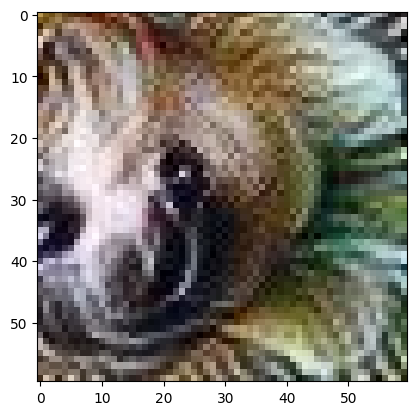

[{'score': 0.2734731137752533, 'label': 'stripes'}, {'score': 0.2641175389289856, 'label': 'snout'}, {'score': 0.10528557002544403, 'label': 'fluff'}, {'score': 0.059193264693021774, 'label': 'beak'}, {'score': 0.04036129638552666, 'label': 'fur'}, {'score': 0.03821279853582382, 'label': 'eyes'}, {'score': 0.036631882190704346, 'label': 'grass'}, {'score': 0.027014054358005524, 'label': 'skin'}, {'score': 0.025271572172641754, 'label': 'hair'}, {'score': 0.023694893345236778, 'label': 'wings'}, {'score': 0.023467307910323143, 'label': 'sky'}, {'score': 0.018087152391672134, 'label': 'wheels'}, {'score': 0.016681840643286705, 'label': 'ears'}, {'score': 0.014122416265308857, 'label': 'windows'}, {'score': 0.01128965150564909, 'label': 'bushes'}, {'score': 0.006737726740539074, 'label': 'clouds'}, {'score': 0.006104562431573868, 'label': 'clothing'}, {'score': 0.004541052971035242, 'label': 'trees'}, {'score': 0.0035037670750170946, 'label': 'doors'}, {'score': 0.0022085383534431458, 'la

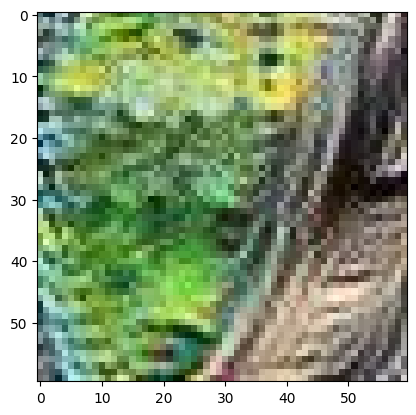

[{'score': 0.22845467925071716, 'label': 'grass'}, {'score': 0.1807645857334137, 'label': 'beak'}, {'score': 0.11228232085704803, 'label': 'bushes'}, {'score': 0.09025907516479492, 'label': 'skin'}, {'score': 0.07226519286632538, 'label': 'snout'}, {'score': 0.06793505698442459, 'label': 'eyes'}, {'score': 0.04045607149600983, 'label': 'stripes'}, {'score': 0.036640800535678864, 'label': 'trees'}, {'score': 0.031134866178035736, 'label': 'windows'}, {'score': 0.025183742865920067, 'label': 'ears'}, {'score': 0.02373816817998886, 'label': 'hair'}, {'score': 0.020760396495461464, 'label': 'clothing'}, {'score': 0.013701098039746284, 'label': 'sky'}, {'score': 0.012202732264995575, 'label': 'clouds'}, {'score': 0.010869576595723629, 'label': 'fur'}, {'score': 0.010704835876822472, 'label': 'wings'}, {'score': 0.008592919446527958, 'label': 'water'}, {'score': 0.006415393203496933, 'label': 'fluff'}, {'score': 0.0038716255221515894, 'label': 'doors'}, {'score': 0.003766885958611965, 'label

In [ ]:
results = [[]] * len(grid_images)


# need to find a way to display the images
for i in range(len(grid_images)):
  current_results = classifier(grid_images[i], candidate_labels=candidate_labels)
  for j in range(len(current_results)):
    results[i].append(current_results[j])
    if j in random_nums:
    #if j in range(113,120):
      print('{}, image {}'.format(layers[i], j))
      print_pic(grid_images[i][j])
      print('{}\n'.format(results[i][j]))